# Introduction to Data Science
## Fitting models and overfitting




### Packages

In [1]:
# Import the libraries we will be using

import os
import numpy as np
import pandas as pd
import math
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline
sns.set(style='ticks', palette='Set2')

# some custom libraries!
import sys
sys.path.append("..")
from ds_utils.decision_surface import *

Notice that we're importing library code that we've developed just for this class. In the future, new common code will continue to be added to the `ds_utils` folder.

Have some code use use frequently? Consider adding it to that folder as your own library!

### A Tiny Motivational Example

Imagine we have some noisy observations from a nonlinear function. We're going to approximate that function by fitting a polynomial to the observations. 

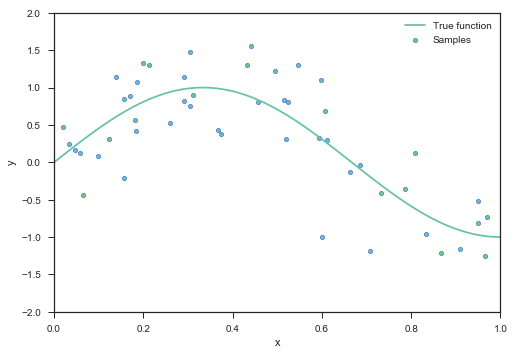

In [2]:
num_samples = 50
np.random.seed(42)

def true_function(X):
    return np.sin(1.5 * np.pi * X)

# range of [0, 1]
X = np.sort(np.random.rand(num_samples))

# add some random noise to the observation
y = true_function(X) + np.random.randn(num_samples) * 0.5

X_test = np.linspace(0, 1, 100)

plt.plot(X_test, true_function(X_test), label="True function")
plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim((0, 1))
plt.ylim((-2, 2))
plt.legend(loc="best")
plt.show()

Let's assume that we don't know the true function, choosing to model our noisy observations using linear regression (from last class).

In [3]:
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

def fit_linear(X, y):
    linear_regression = LinearRegression()
    linear_regression.fit(X[:, np.newaxis], y)
    
    return linear_regression

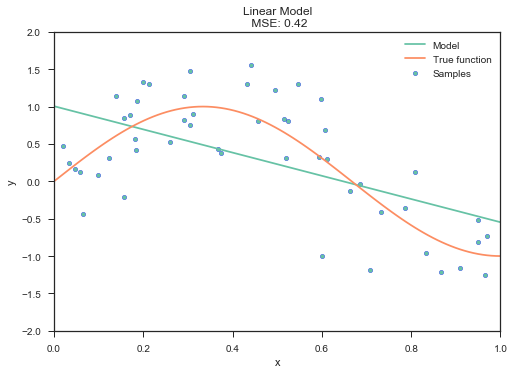

In [4]:
from sklearn.metrics import mean_squared_error

linear = fit_linear(X, y)
mse = mean_squared_error(y, linear.predict(X[:, np.newaxis]))

X_test = np.linspace(0, 1, 100)
plt.plot(X_test, linear.predict(X_test[:, np.newaxis]), label="Model")
plt.plot(X_test, true_function(X_test), label="True function")
plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim((0, 1))
plt.ylim((-2, 2))
plt.legend(loc="best")
plt.title("Linear Model\n MSE: %.2f" % mse)
plt.show()

Clearly the linear regression doesn't fit our data well. Rather than trying a linear regression, let's attempt polynomial regression. How do different degree polynomials fit the data? Recall that a polynomial on a single variable looks like:

$$ a_1 + a_2 x + a_3 x^2 + ... $$

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def fit_polynomial(X, y, degree):
    # create different powers of X
    polynomial_features = PolynomialFeatures(degree=degree,
                                             include_bias=False)
    linear_regression = LinearRegression()
    
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)
    
    return pipeline

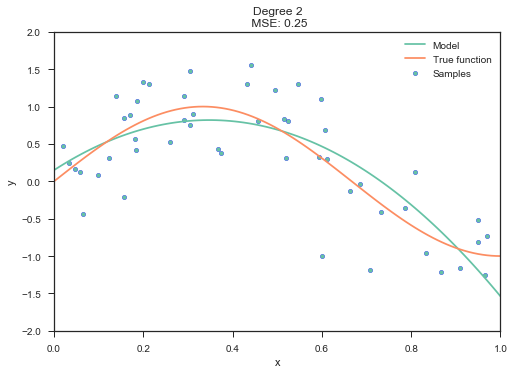

In [6]:
degree = 2
def plot_fit(X, y, degree, xmin=0, xmax=1, ymin=-2, ymax=2):
    poly = fit_polynomial(X, y, degree)
    mse = mean_squared_error(y, poly.predict(X[:, np.newaxis]))

    X_test = np.linspace(xmin, xmax, 100)
    plt.plot(X_test, poly.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_function(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((xmin, xmax))
    plt.ylim((ymin, ymax))
    plt.legend(loc="best")
    plt.title("Degree %d\n MSE: %.2f" % (degree, mse))
    
plot_fit(X, y, degree)
plt.show()

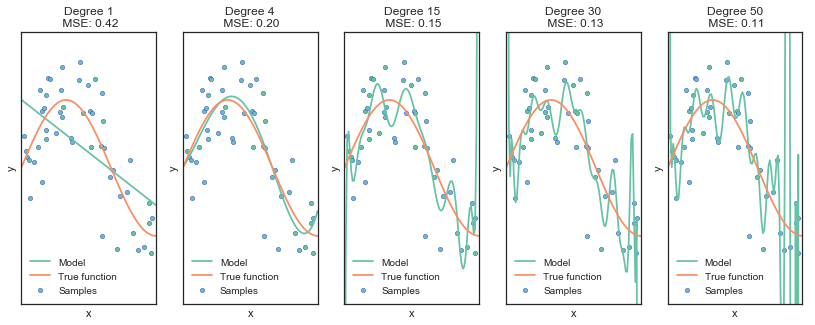

In [7]:
plt.figure(figsize=(14, 5))

# degrees of the polynomial
degrees = [1, 4, 15, 30, 50]

for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())
    plot_fit(X, y, degrees[i])
    
plt.show()

### HTRU: A More Concrete Example

HTRU2 is a data set which describes a sample of pulsar candidates collected during the High Time Resolution Universe Survey (South). Pulsars are a rare type of Neutron star that produce radio emission detectable here on Earth. They are of considerable scientific interest as probes of space-time, the inter-stellar medium, and states of matter. 

As pulsars rotate, their emission beam sweeps across the sky, and when this crosses our line of sight, produces a detectable pattern of broadband radio emission. As pulsars 
rotate rapidly, this pattern repeats periodically. Thus pulsar search involves looking for periodic radio signals with large radio telescopes. 

Each pulsar produces a slightly different emission pattern, which varies slightly with each rotation. Thus a potential signal detection known as a 'candidate', is averaged over many rotations of the pulsar, as determined by the length of an observation. In the absence of additional info, each candidate could potentially describe a real pulsar. However in practice almost all detections are caused by radio frequency interference (RFI) and noise, making legitimate signals hard to find.

In [8]:
url = "https://gist.githubusercontent.com/jattenberg/0b82457bad3234f892972948f62b2489/raw/a3f055a431bda3b149c3eefc2a03c33f6983a32a/HTRU%25202.csv"
predictor_columns = ["ip mean", "ip std dev", "ip kurtosis", "ip skewness",
                     "dm-snr mean", "dm-snr std dev", "dm-snr kurtosis", "dm-snr skewness"]
column_names = predictor_columns + ["class"]

htru_df = pd.read_csv(url, header=None, names=column_names).dropna()

Let's briefly explore the data

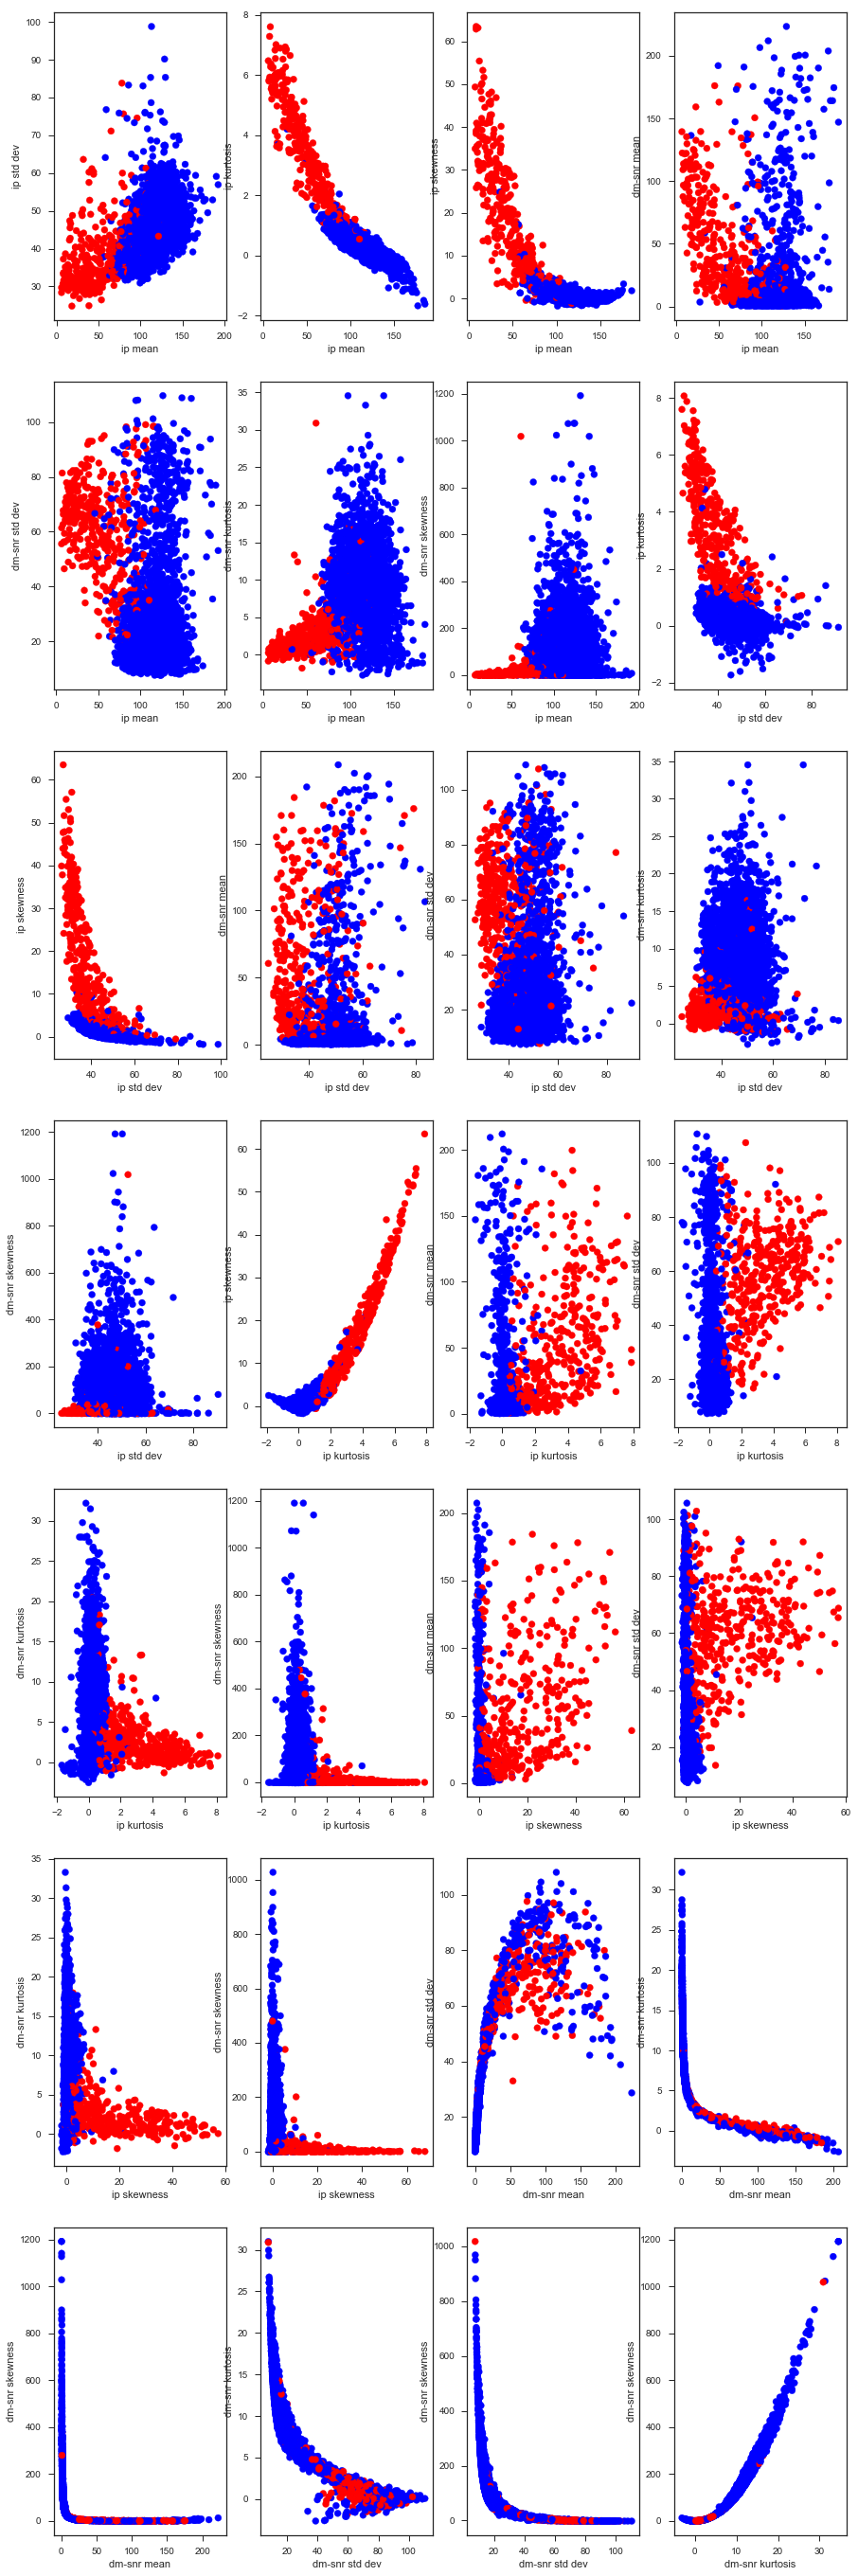

In [9]:
# c(8, 2) ways to select the data = 8!/(2!6!) = 8*7/2 = 28 = 4*7 
# so we'll do 7 rows and 4 columns

rows = 7
cols = 4
ct = 0
plt.figure(figsize=[15,7*rows])
for i in range(len(predictor_columns) - 1):
    for j in range(i+1, len(predictor_columns)):
        ct = ct + 1
        plt.subplot(rows, cols, ct)
        xlabel = predictor_columns[i]
        ylabel = predictor_columns[j]
        Decision_Surface(htru_df[predictor_columns], xlabel, ylabel, htru_df["class"], None, sample=0.25)

## Tree-structured models
Let's now re-explore the modeling technique we introduced last class -- tree-structured models.  And in particular, classification trees, since our target is to predict whether or not a star is a pulsar (binary classification).

## Trees are non-linear models

If you experiment with the tree depth, you will see that you can fit the data better and better. Deeper trees produce chop the instance space into smaller and smaller pieces.  Try it above, using the `depths` variable.  (Will this finer and finer segmentation go on forever?)

**Extra:** Can you visualize the actual tree-structured model?  Hint: there's a function to do it in last week's notebook.

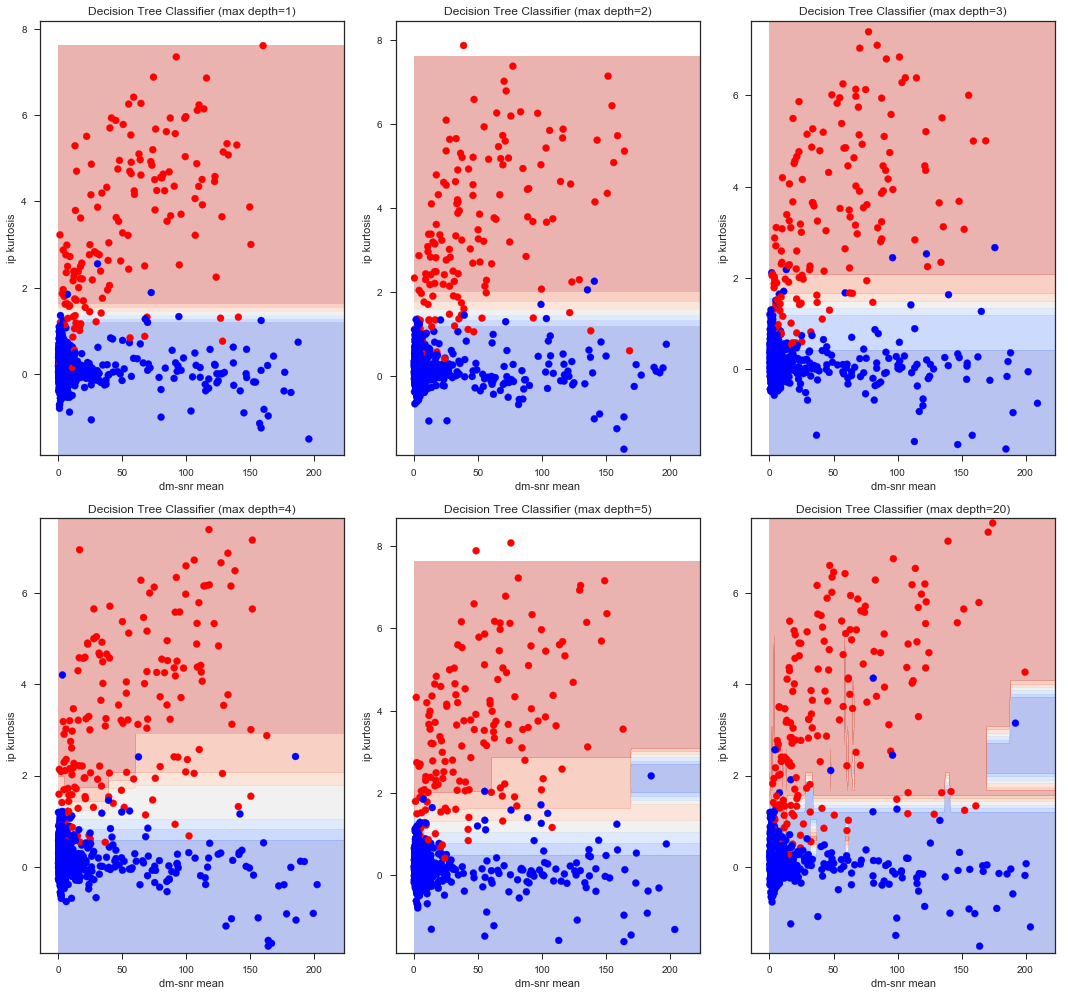

In [10]:
from sklearn.tree import DecisionTreeClassifier

depths = [1,2,3,4,5,20] 
show_probabilities = True


nrows = np.floor(np.sqrt(len(depths)))
ncol = 2 if len(depths) == 4 else 3
plt.figure(figsize=[15,7*nrows])

position = 1
for i in range(len(depths)):

    depth = depths[i] 
    
    # Plot
    plt.subplot(nrows, ncol, 1+i)
    Decision_Surface(htru_df[predictor_columns], "dm-snr mean", "ip kurtosis", htru_df["class"], DecisionTreeClassifier(max_depth=depth, criterion="entropy"), True, sample=0.1)
    plt.title("Decision Tree Classifier (max depth=" + str(depth) + ")")
    
plt.tight_layout()
plt.show()


## Linear discriminant models

Chapter 4 introduces linear models.  Let's try building one on this data set. 

Looking at the data (see scatterplot above), can you estimate by eye where a good linear discriminant would be?

We will build a **Logistic regression** model. You can also find logistic regression modeling in the sklearn package.

If you remember, linear regression looks like this:

$$ y = b + a_1 x_1 + a_2 x_2 + a_3 x_3 + ... $$

If you are estimating the probability between two different classes, traditional linear regression may not work as well as you hope. Probabilities need to be bounded between zero and one. To solve this problem, a common tool is to use a logistic regression model.

Let's plot a linear regression curve to see what it looks like.

In [11]:
def plot_linear(X, y, model, predict_fn, title, ymin=-0.1, ymax=1.1, sample=0.1):
    model.fit(X.reshape(-1, 1), y)
    
    
    y_hat = predict_fn(model, X.reshape(-1, 1))
    mse = mean_squared_error(y, y_hat)
    
    X_test = np.linspace(X.min(), X.max(), 100)
    plt.plot(X_test, predict_fn(model, X_test.reshape(-1, 1)))
    
    # sample for plotting
    indices = np.random.permutation(range(len(y)))[:int(sample*len(y))].tolist()
    
    plt.scatter(X[indices], y[indices], edgecolor='b')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((X.min(), X.max()))
    plt.ylim((ymin, ymax))

    plt.title("%s, MSE %0.3f" % (title, mse))
    
def linear_predict(model, X):
    return model.predict(X)

def logistic_predict(model, X):
    return model.predict_proba(X)[:, 1]

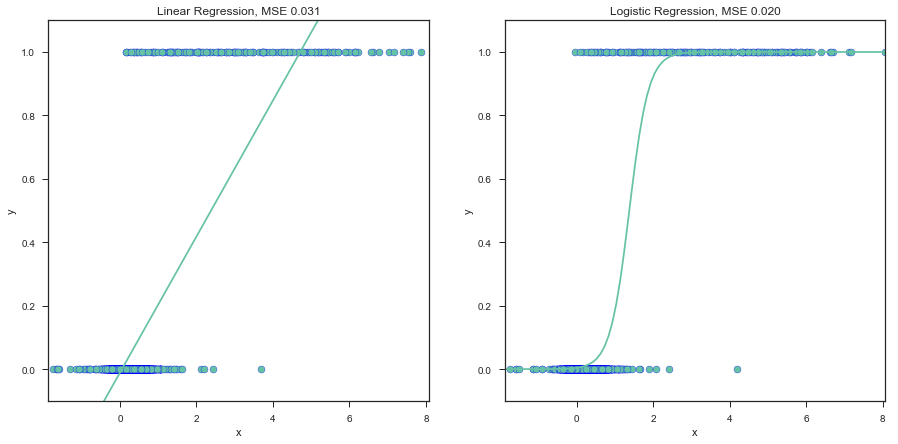

In [12]:
from sklearn.linear_model import LogisticRegression

plt.figure(figsize=[15,7])
plt.subplot(1, 2, 1)

plot_linear(htru_df["ip kurtosis"], htru_df["class"], LinearRegression(), linear_predict, "Linear Regression")

plt.subplot(1,2,2)
plot_linear(htru_df["ip kurtosis"], htru_df["class"], LogisticRegression(), logistic_predict, "Logistic Regression")


And, of course, we can look at the decision surface produced by linear and logistic regression

In [13]:
from sklearn.metrics import accuracy_score

def training_accy(X, y, model):
    y_hat = model.fit(X, y).predict(X)
    return accuracy_score(y, [1 if ty > 0.5 else 0 for ty in y_hat])

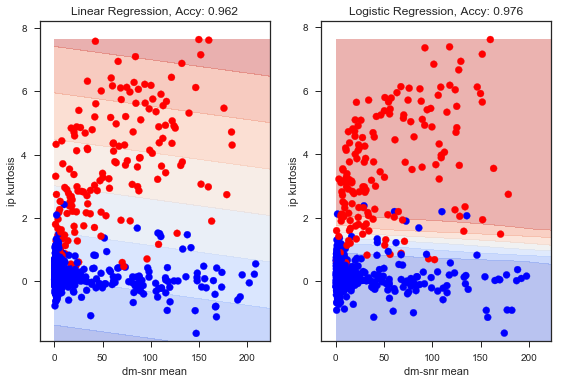

In [14]:
plt.subplot(1, 2, 1)
Decision_Surface(htru_df[predictor_columns], "dm-snr mean", "ip kurtosis", htru_df["class"], LinearRegression(), probabilities=False, sample=0.1)
lin_accy = training_accy(htru_df[["dm-snr mean", "ip kurtosis"]], htru_df["class"], LinearRegression())
plt.title("Linear Regression, Accy: %0.3f" % lin_accy)

plt.subplot(1, 2, 2)
Decision_Surface(htru_df[predictor_columns], "dm-snr mean", "ip kurtosis", htru_df["class"], LogisticRegression(), probabilities=True, sample=0.1)
lr_accy = training_accy(htru_df[["dm-snr mean", "ip kurtosis"]], htru_df["class"], LogisticRegression())
plt.title("Logistic Regression, Accy: %0.3f" % lr_accy)

plt.tight_layout()
plt.show()

### Estimating Probabilities


For many business problems, we don't need just to estimate the categorical target variable, but we want to estimate the probability that a particular value will be taken. Just about every classification model can also tell you the estimated probability of class membership.

Intuitively, how would you generate probabilities from a classification tree? From a linear discriminant?

Let's go back and look at the probabilities estimated by these models. You can visualize the probabilities both for the linear model and the tree-structured model. You can do this by modifying the settings at the top of each code block above (show_probabilities = True or False).

Note that the native `LinearRegression` class in sklearn doesn't have probability estimation capability (Why do you think?). We can only perform this with operation with logistic regression.

### Non-linear models

We saw that tree-structured models can fit the data very well. It seems like a linear model possibly cannot. Can we use the idea of fitting linear models to generate non-linear boundaries with logistic regression?

Yes! We can do this by adding non-linear features, such as  $ x^2 $  or  $ x^3 $ for any feature $ x $. We can even perform a fully set of polynomial feature interactions: given input features $x_1$ and $x_2$, we can, for instance,  perfom modeling and prediction on $x_1 + x_2 + x_1^2 + x_2^2 + x_1x_2$.

This is one of the most common ways of introducing non-linearity into numeric function modeling: use a linear function learner, but introduce non-linear features.

In [15]:
def polynomial_model(model=LogisticRegression(), degree=1):
    polynomial_features = PolynomialFeatures(degree=degree,
                                             include_bias=False)
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("model", model)])
    
    return pipeline

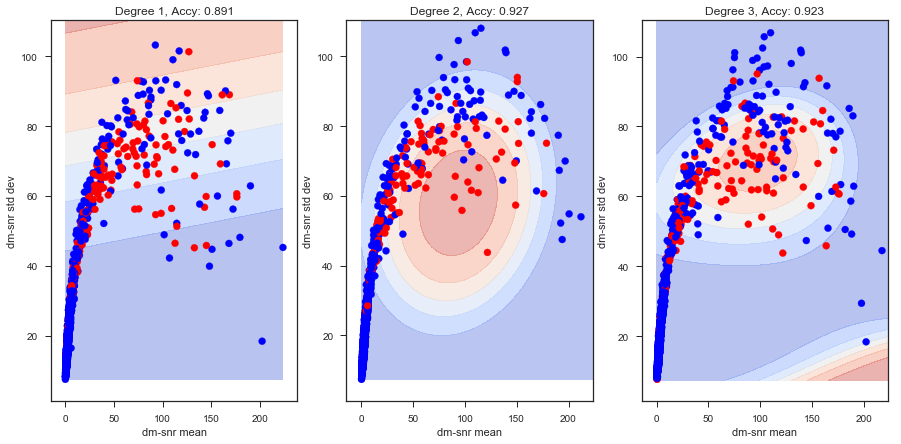

In [16]:
plt.figure(figsize=[15,7])

degrees = [1,2,3]
for i in range(len(degrees)):
    model = polynomial_model(LogisticRegression(), degrees[i])
    plt.subplot(1, len(degrees), i+1)
    
    Decision_Surface(htru_df[predictor_columns], "dm-snr mean", "dm-snr std dev", htru_df["class"], model, probabilities=True, sample=0.1)
    accy = training_accy(htru_df[["dm-snr mean", "dm-snr std dev"]], htru_df["class"], model)
    plt.title("Degree %d, Accy: %0.3f" % (degrees[i], accy))
plt.show()
    

## Regularization
There are a few ways to control the complexity of predictive models. One common way is called **regularization**. Regularization decreases model complexity and brings predictions closer to the "average" value of the data set by decreasing the weights on the coefficients.

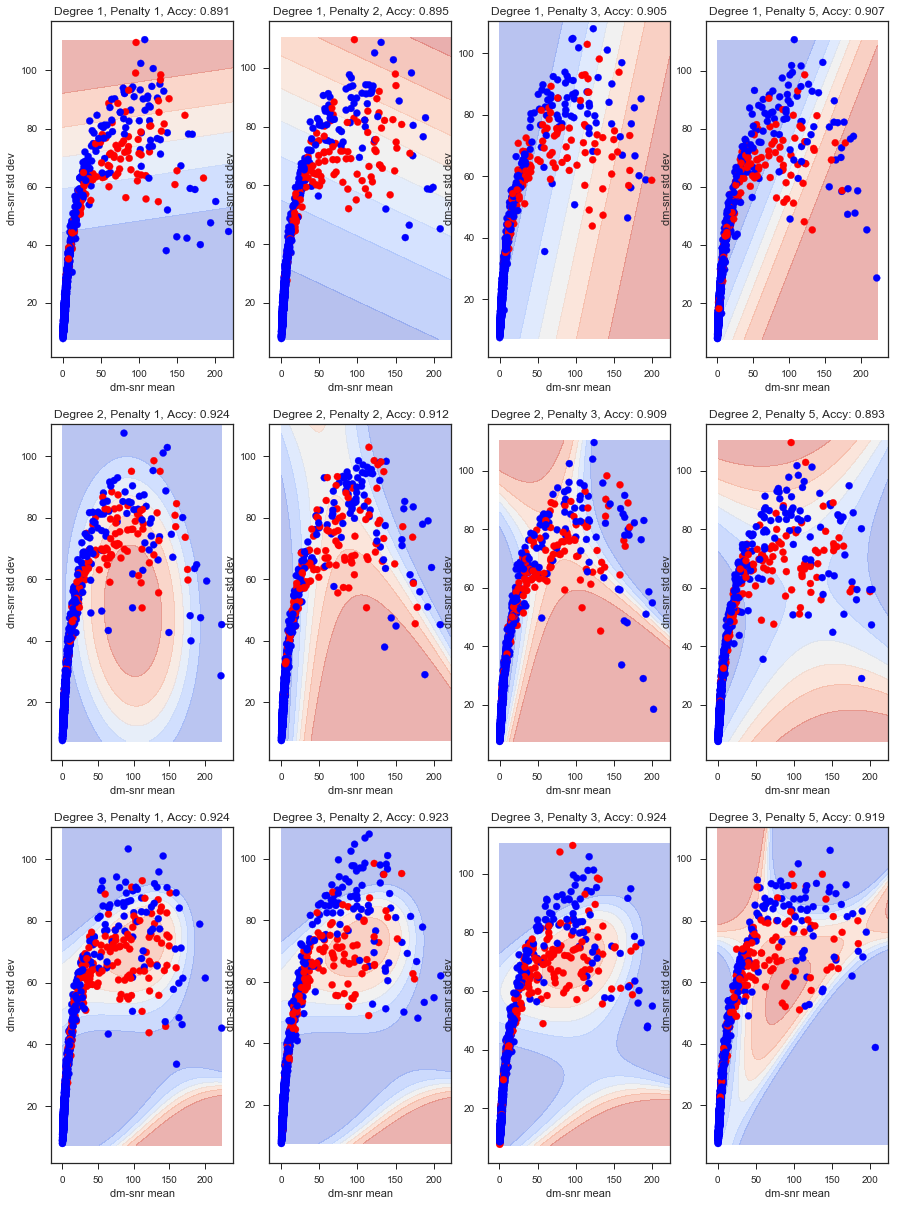

In [17]:
degrees = [1,2,3]
penalties = [1,2,3,5]
penalty_type = "l2"

plt.figure(figsize=[15,7*len(degrees)])
ct = 0
for i in range(len(degrees)):
    for j in range(len(penalties)):
        ct = ct + 1
        base_model = LogisticRegression(penalty=penalty_type, C=10**(-penalties[j]))
        model = polynomial_model(base_model, degrees[i])
        
        plt.subplot(len(degrees), len(penalties), ct)
    
        Decision_Surface(htru_df[predictor_columns], "dm-snr mean", "dm-snr std dev", htru_df["class"], model, probabilities=True, sample=0.1)
        
        accy = training_accy(htru_df[["dm-snr mean", "dm-snr std dev"]], htru_df["class"], model)
        plt.title("Degree %d, Penalty %d, Accy: %0.3f" % (degrees[i], penalties[j], accy))
plt.show()

Which model is better in this case?? Look at the **accuracy** of each one. Accuracy is simply the count of correct decisions divided by the total number of decisions. Here we are computing the accuracy of the model when it makes predictions on the training set, examples the model "already knows the answer to". 

[From sklearn documentation on sklearn.metrics.accuracy_score: "In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true."  [More about the accuracy measure..](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)]

## Generalization

Our evaluation above actually was not what we really want.

What we want are models that **generalize** to data that were not used to build them! In other words, we want this model to be able to predict the target for new data instances! Do we know how well our models generalize? Why is this important?

<img src="images/generalization.png" alt="Drawing" style="width: 600px;"/>


Let's apply this concept to our data. Now, before we fit out models, we set aside some data to be used later for testing ('holdout data').  This allows us to assess whether the model simply fit the training dataset well, or whether it truly fit some regularities in the domain. 

Let's use sklearn to set aside some randomly selected holdout data.

In [18]:
from sklearn.model_selection import train_test_split

# Set randomness so that we all get the same answer
np.random.seed(42)

# Split the data into train and test pieces for both X and Y
X_train, X_test, Y_train, Y_test = train_test_split(htru_df[predictor_columns], htru_df["class"], train_size=0.80)

In [19]:
model = DecisionTreeClassifier(max_depth=10)
model.fit(X_train, Y_train)

print ( "Accuracy on training = %.4f" % accuracy_score(model.predict(X_train), Y_train) )
print ( "Accuracy on test = %.4f" % accuracy_score(model.predict(X_test), Y_test) )

Accuracy on training = 0.9920
Accuracy on test = 0.9751


Accuracy on the training set is better than on the test set! Why is this? What can we do to make things better? What happens if our tree gets even deeper? 

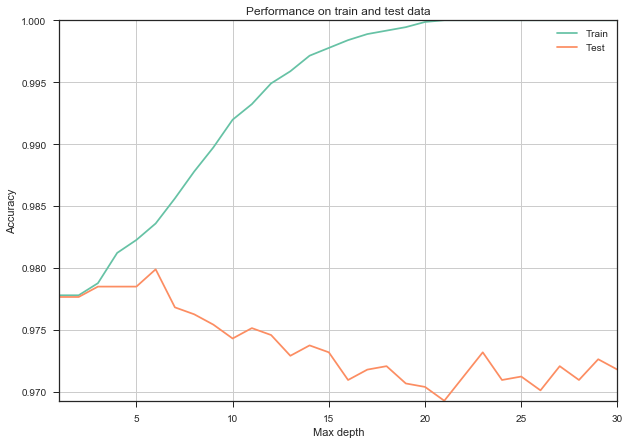

In [20]:
accuracies_train = []
accuracies_test = []
maxdepth = 30
depths = range(1, maxdepth+1)

plt.figure(figsize=[10,7])

for md in depths:
    model = DecisionTreeClassifier(max_depth=md)
    model.fit(X_train, Y_train)
    
    accuracies_train.append(accuracy_score(model.predict(X_train), Y_train))
    accuracies_test.append(accuracy_score(model.predict(X_test), Y_test))

plt.plot(depths, accuracies_train, label="Train")
plt.plot(depths, accuracies_test, label="Test")
plt.title("Performance on train and test data")
plt.xlabel("Max depth")
plt.ylabel("Accuracy")
plt.ylim([min(accuracies_test), 1.0])
plt.xlim([1,maxdepth])
plt.legend()
plt.grid()
plt.show()

98% accuracy for just one split on the decision tree! This seems too good to be true! Let's take a look at the split of labels for our data.

In [21]:
htru_df["class"].value_counts()

0    16259
1     1639
Name: class, dtype: int64

10:1! This means, we could get 90% accuracy just by labeling the majority class. Perhaps we should use a different metric? For the remainder, we'll use [AUC](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html), A metric that solves some of the problems with basic accuracy. More on this next time!

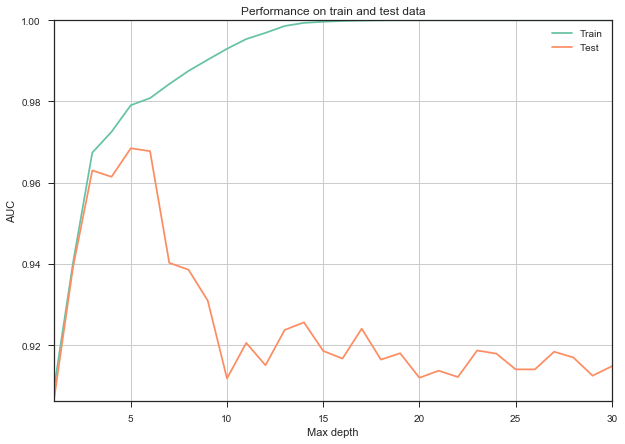

In [22]:
from sklearn.metrics import roc_auc_score

aucs_train = []
aucs_test = []
maxdepth = 30
depths = range(1, maxdepth+1)

plt.figure(figsize=[10,7])

for md in depths:
    model = DecisionTreeClassifier(max_depth=md)
    model.fit(X_train, Y_train)
    
    aucs_train.append(roc_auc_score(Y_train, model.predict_proba(X_train)[:, 1] ))
    aucs_test.append(roc_auc_score(Y_test, model.predict_proba(X_test)[:, 1]))

plt.plot(depths, aucs_train, label="Train")
plt.plot(depths, aucs_test, label="Test")
plt.title("Performance on train and test data")
plt.xlabel("Max depth")
plt.ylabel("AUC")
plt.ylim([min(aucs_test), 1.0])
plt.xlim([1,maxdepth])
plt.legend()
plt.grid()
plt.show()

## Cross validation

Above, we made a single train/test split. We set aside 20% of our data and *never* used it for training. We also never used the 80% of the data set aside for training to test generalizability.  Although this is far better than testing on the training data, which does not measure generalization performance at all, there are two potential problems with the simple holdout approach.

1) Perhaps the random split was particularly bad (or good).  Do we have any confidence in our accuracy estimate?

2) We are using only 20% of the data for testing.  Could we possibly use the data more fully for testing?

3) Often we want to know something about the distribution of our evaluation metrics. A simple train/test split only allows a single "point estimate"

Instead of only making the split once, let's use "cross-validation" -- every record will contribute to testing as well as to training.


<img src="images/cross.png" alt="Drawing" style="width: 600px;"/>

In [23]:
from sklearn.model_selection import cross_val_score

model = DecisionTreeClassifier(max_depth=10)
scores = cross_val_score(model, htru_df[predictor_columns], htru_df["class"], scoring="roc_auc")

print ("Cross Validated AUC: %0.3f +/- %0.3f" % (scores.mean(), scores.std()))

Cross Validated AUC: 0.915 +/- 0.010


We can add this cross-validated accuracy to our plot above

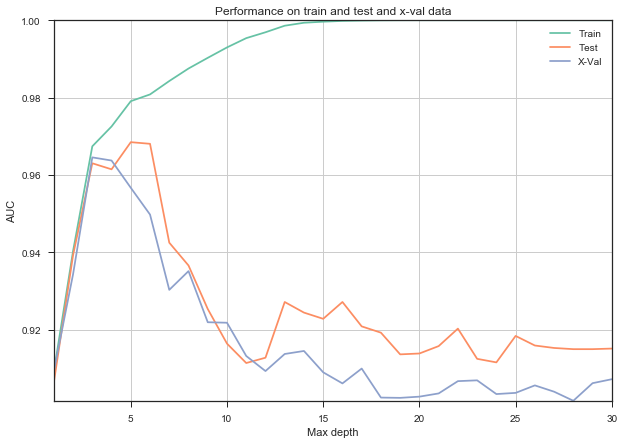

In [24]:
aucs_train = []
aucs_test = []
aucs_xval = []
maxdepth = 30
depths = range(1, maxdepth+1)

plt.figure(figsize=[10,7])

for md in depths:
    model = DecisionTreeClassifier(max_depth=md)
    model.fit(X_train, Y_train)
    
    aucs_train.append(roc_auc_score(Y_train, model.predict_proba(X_train)[:,1]))
    aucs_test.append(roc_auc_score(Y_test, model.predict_proba(X_test)[:,1]))
    
    scores = cross_val_score(model, X_train, Y_train, scoring="roc_auc")
    aucs_xval.append(scores.mean())

plt.plot(depths, aucs_train, label="Train")
plt.plot(depths, aucs_test, label="Test")
plt.plot(depths, aucs_xval, label="X-Val")
plt.title("Performance on train and test and x-val data")
plt.xlabel("Max depth")
plt.ylabel("AUC")
plt.ylim([min(aucs_test + aucs_xval), 1.0])
plt.xlim([1,maxdepth])
plt.legend()
plt.grid()
plt.show()

### Grid Search: Combining Cross Validation with Hyper-Parameter Tuning
As we've seen, many machine learning models have additional parameters that are set that have an impact on how the model learns its intended problem, for instance, the degree of polynomial features or the amount of regularization performed to control complexity. These "knobs" are called "hyper-paramaters" in the machine learning community. (Because the coeffiecients of the model are called the "parameters".)

Previously, we've manually set a number of values for different parameters and assessed the performance of the end predictive system. This concept can be formalized and automated, by defining a grid of parameters and using cross validation to chose the best values. 

{'C': 2.0}
0.9751545645746013


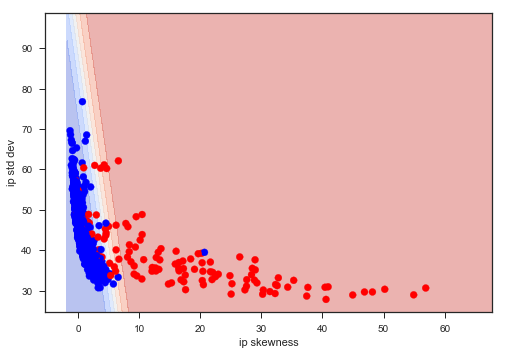

In [25]:
from sklearn.model_selection import GridSearchCV

grid = {
    'C':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0]
}

tuned_lr = GridSearchCV(LogisticRegression(), grid, scoring="roc_auc")
tuned_lr.fit(htru_df[predictor_columns], htru_df["class"])

print (tuned_lr.best_params_)
print (tuned_lr.best_score_)

Decision_Surface(htru_df[predictor_columns], "ip skewness", "ip std dev", htru_df["class"], tuned_lr, True, sample=0.1)


Could we also tune the degree of polynomial features along with the level of regression?

### Learning Curves

As one might expect, the performance of a model is tightly coupled to the amount of data available during training. Intuitively, the more observations a model has of its intended task, the more it can potentially know about the world, and the more accurately it can predict. 

Let's look at how the amount of training data impacts the accuracy of the model. 

In [26]:
from sklearn import model_selection as cv

def crossvalidate_sample(X, y, model, pct):
    kf = cv.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_index, test_index in kf.split(X, y):
        
        # only take a portion of the training
        sampled_indices = np.random.permutation(range(len(train_index)))[:int(pct*len(train_index))].tolist()
        np_train = np.array(train_index)
        to_get = np_train[sampled_indices]

        model.fit(X.loc[to_get], y[to_get])
            
        y_hat = model.predict_proba(X.loc[test_index])[:,1]
        scores.append(roc_auc_score(y[test_index], y_hat))
    return scores

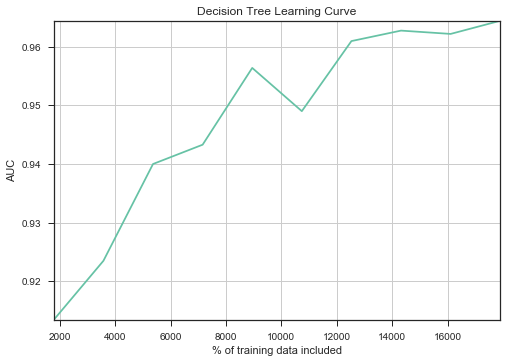

In [27]:
pcts = [(r+1.0)/10.0 for r in range(0, 10)]

model = DecisionTreeClassifier(max_depth=5)
tree_learning_curve_scores = []
for pct in pcts:
    scores = crossvalidate_sample(htru_df[predictor_columns], htru_df["class"], model, pct)
    tree_learning_curve_scores.append(np.mean(scores))

counts = [htru_df["class"].count()*pct for pct in pcts]

plt.plot(counts, tree_learning_curve_scores)
plt.title("Decision Tree Learning Curve")
plt.xlabel("% of training data included")
plt.ylabel("AUC")
plt.ylim([min(tree_learning_curve_scores), max(tree_learning_curve_scores)])
plt.xlim([min(counts), max(counts)])
plt.legend()
plt.grid()
plt.show()

How does the learning curve of the classification tree compare to that of logistic regression?

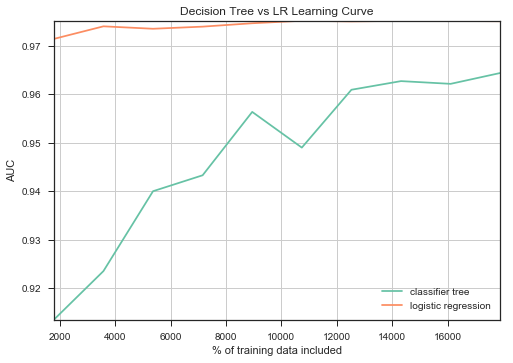

In [28]:
lr = LogisticRegression()
lr_learning_curve_scores = []
for pct in pcts:
    scores = crossvalidate_sample(htru_df[predictor_columns], htru_df["class"], lr, pct)
    lr_learning_curve_scores.append(np.mean(scores))
    
plt.plot(counts, tree_learning_curve_scores, label="classifier tree")
plt.plot(counts, lr_learning_curve_scores, label="logistic regression")
plt.title("Decision Tree vs LR Learning Curve")
plt.xlabel("% of training data included")
plt.ylabel("AUC")
plt.ylim([min(tree_learning_curve_scores+lr_learning_curve_scores), max(tree_learning_curve_scores+lr_learning_curve_scores)])
plt.xlim(min(counts), max(counts))
plt.legend(loc="lower right")
plt.grid()
plt.show()

How about viewing on the log scale?

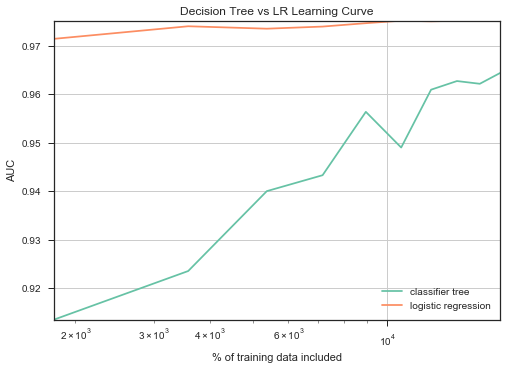

In [29]:
plt.plot(counts, tree_learning_curve_scores, label="classifier tree")
plt.plot(counts, lr_learning_curve_scores, label="logistic regression")
plt.title("Decision Tree vs LR Learning Curve")
plt.xlabel("% of training data included")
plt.ylabel("AUC")
plt.ylim([min(tree_learning_curve_scores+lr_learning_curve_scores), max(tree_learning_curve_scores+lr_learning_curve_scores)])
plt.xlim(min(counts), max(counts))
plt.xscale('log')
plt.legend(loc="lower right")
plt.grid()
plt.show()

With a more expressive classifier

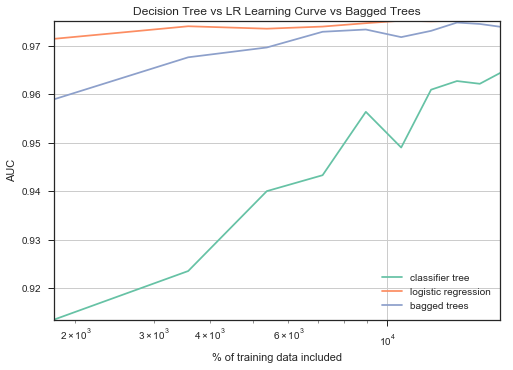

In [30]:
from sklearn.ensemble import BaggingClassifier

bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=8), n_estimators=10)
bag_learning_curve_scores = []
for pct in pcts:
    scores = crossvalidate_sample(htru_df[predictor_columns], htru_df["class"], bag, pct)
    bag_learning_curve_scores.append(np.mean(scores))
    
plt.plot(counts, tree_learning_curve_scores, label="classifier tree")
plt.plot(counts, lr_learning_curve_scores, label="logistic regression")
plt.plot(counts, bag_learning_curve_scores, label="bagged trees")
plt.title("Decision Tree vs LR Learning Curve vs Bagged Trees")
plt.xlabel("% of training data included")
plt.ylabel("AUC")
plt.ylim([min(tree_learning_curve_scores+lr_learning_curve_scores+bag_learning_curve_scores), max(tree_learning_curve_scores+lr_learning_curve_scores+bag_learning_curve_scores)])
plt.xlim(min(counts), max(counts))
plt.xscale('log')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Let's compare what these classifiers are doing

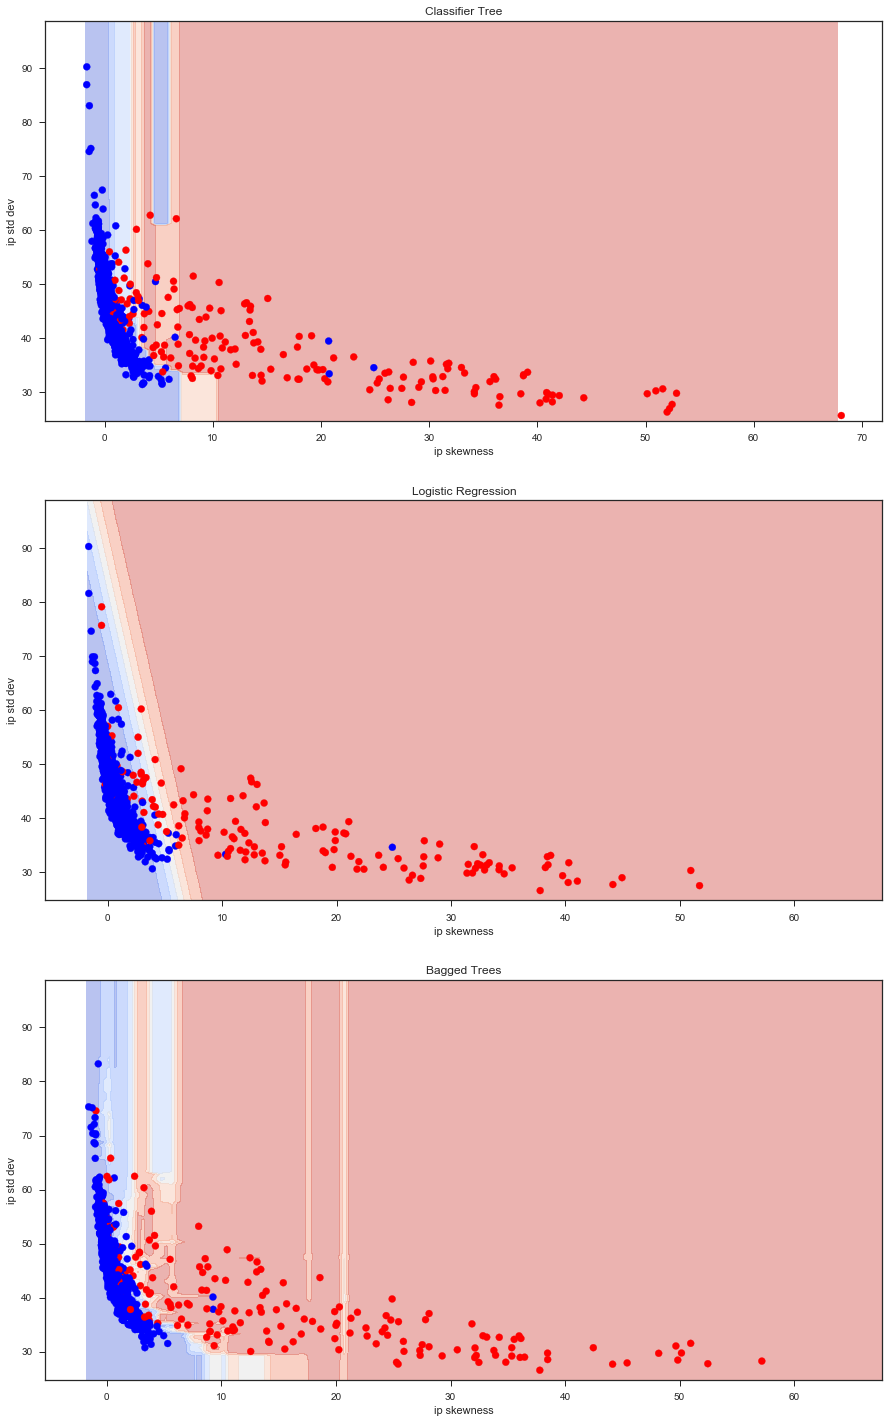

In [31]:
models = [DecisionTreeClassifier(max_depth=5), LogisticRegression(), BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=8), n_estimators=30)]
names = ["Classifier Tree", "Logistic Regression", "Bagged Trees"]

plt.figure(figsize=[15,25])
for i in range(len(models)):
    plt.subplot(3, 1, i+1)
    Decision_Surface(htru_df[predictor_columns], "ip skewness", "ip std dev", htru_df["class"], models[i], True, sample=0.1)
    plt.title(names[i])
plt.show()